# 7 Quantum Circuits


## 7.1 What do you need for a quantum computation? 

The predominant model of quantum computing is the circuit model. 

A quantum circuit is a diagram showing the operations that act on qubits to carry out a computation. All quantum circuits have 3 parts:

1. Initialisation: Start your qubits in an initial quantum state
2. Computation: Perform a series of single and 2 qubit gates 
3. Measurement: Measure the qubits 

Many quantum algorithms will also interface with a classical computer. This is very application-specific so it will be covered later. 


### 7.1.1 Hello quantum world

In this course the open-source quantum development kit, Qiskit (pronounced kiss-ket) will be used. It is developed by IBM and has the greatest support including: 

- An entire [textbook on how to use it](https://qiskit.org/textbook/preface.html) 
- Many YouTube tutorials (by IBM and 3rd parties)
- Many hackathons organised by IBM and others use Qikist
- Excellent [documentation](https://qiskit.org/documentation/) 
- Good compatibility with other gate-based quantum computers

There are two ways to use Qiskit. It can be installed on your local machine or accessed over the cloud (for free) thanks to IBM

In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, ClassicalRegister, QuantumRegister
import qiskit.tools.jupyter
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

from qiskit.providers.fake_provider import FakeBogotaV2 

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

## 7.2  1 + 1 = 2 (most of the time )

A simple quantum circuit can be used to add 2 bits. This example illustrates a basic quantum algorithm, but you would never want to do this. There is no advantage in doing addition on a quantum computer, but this is a useful example of a quantum circuit. 

The adder should do the following: take two qubits and return their sum.


Input 1| Input 0| $\rightarrow$| Output 1 | Output 0  
----- | ----- | ----- | ----- | -----|
0 | 0| | 0 | 0
0 | 1| | 0 | 1
1 | 0 | |0 | 1
1 | 1 | |1 | 0 


For the circuit below, we'll have the top two qubits be the input, and the bottom two qubits be the output. This means when we measure our qubits, the bits to the left will be the output and the bits to the right will be the input

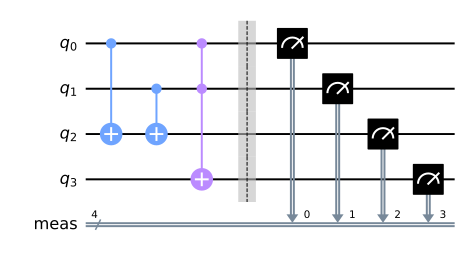

In [ ]:
Adder_circuit = QuantumCircuit(4)

Adder_circuit.cx(0,2)           # CNOT 0 as control, 2 as target
Adder_circuit.cnot(1,2)         # CNOT 1 as control, 2 as target
Adder_circuit.toffoli(0,1,3)    # Toffoli gate with 0,1 as control, 3 as target
Adder_circuit.measure_all() # The choice of measuring all allows the inputs, q0,q1 to be evaluated as well as their sum

Adder_circuit.draw(output='mpl')

Let's test that it works by running some of the senarios. 


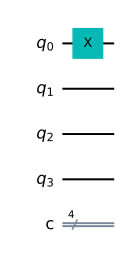

In [4]:
Input_circuit = QuantumCircuit(4,4)

Input_circuit.x(0)


Input_circuit.draw()


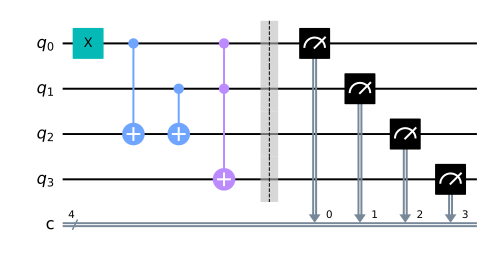

In [5]:
# Now I can combine the input circuit with the adder circuit with .compose()

Combined_circuit = Input_circuit.compose(Adder_circuit)
Combined_circuit.draw()

{'0101': 1024}


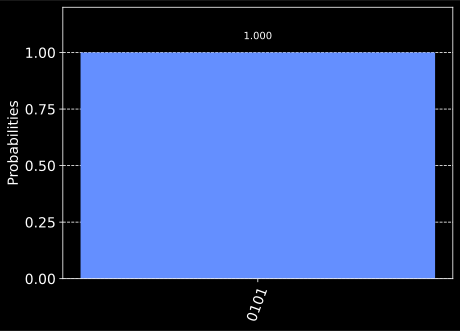

In [6]:
# Let's run the circuit 

sim = Aer.get_backend('aer_simulator')

job = sim.run(Combined_circuit)          # run the experiment on ideal simulator
result = job.result()                      # get the results
counts = result.get_counts()               # interpret the results as a "counts" dictionary
print(counts)
plot_histogram(counts)

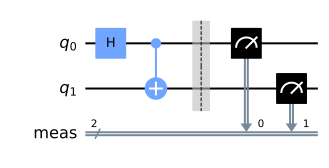

In [7]:
bell_state_creator = QuantumCircuit(2)

bell_state_creator.h(0) # apply hadamard to qubit 0 
bell_state_creator.cnot(0,1)
bell_state_creator.measure_all()

bell_state_creator.draw()

{'11': 495, '00': 529}


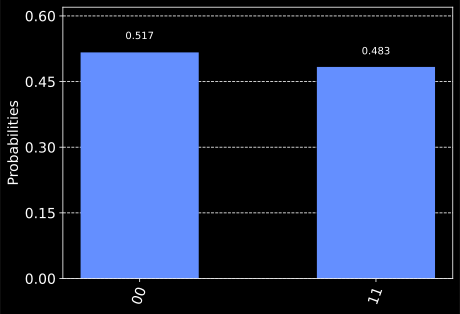

In [8]:
# Let's run it 

job = sim.run(bell_state_creator)          # run the experiment on ideal simulator
result = job.result()                      # get the results
counts = result.get_counts()               # interpret the results as a "counts" dictionary
print(counts)
plot_histogram(counts)

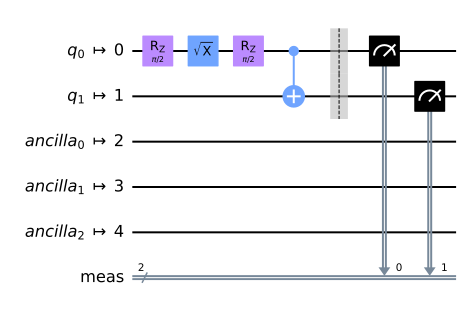

In [9]:
# We don't always get what we want

backend_bogota = FakeBogotaV2()

transpiled_circuit = transpile(bell_state_creator, backend_bogota)

transpiled_circuit.draw(output='mpl')

{'00': 479, '11': 464, '01': 35, '10': 46}


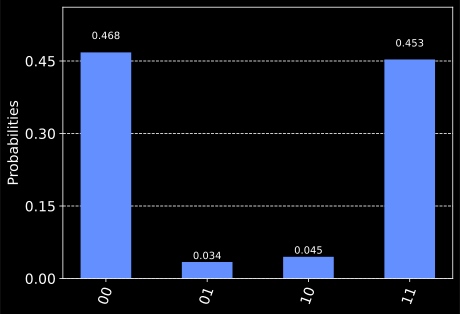

In [10]:
job = backend_bogota.run(transpiled_circuit)                        # run the experiment on ideal simulator
result = job.result()                      # get the results
counts = result.get_counts()               # interpret the results as a "counts" dictionary
print(counts)
plot_histogram(counts)

## 7.3 Quantum Teleportation 

One of the most interesting results of quantum information theory is the ability to teleport an unkown quantum state over unlimited distance (you still have to wait for light to get there). We can explain how this works using quantum circuits 



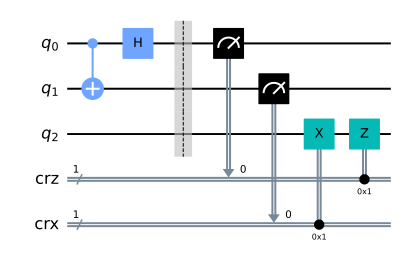

In [11]:
crz = ClassicalRegister(1,name="crz")
crx = ClassicalRegister(1,name="crx")
q = QuantumRegister(3, name='q')

teleporter = QuantumCircuit(q, crz, crx)
teleporter.cnot(0,1)
teleporter.h(0)

teleporter.barrier()
teleporter.measure(0,crz)
teleporter.measure(1,crx)

teleporter.x(2).c_if(crx,1)
teleporter.z(2).c_if(crz,1)

teleporter.draw()


## 7.4 Distributed Quantum Computing 

The teleportation circuit can be modified to create an entangled state of qubits that are far apart. What this allows us to do is to run two qubit gates across qubits that don't have a direct (quantum) connection. 


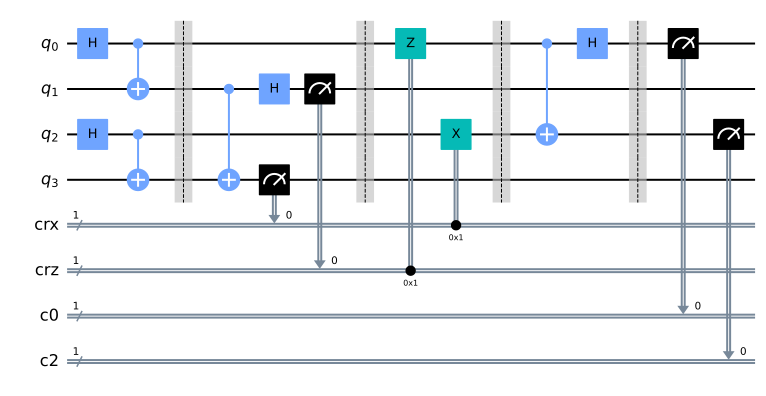

In [12]:
# Circuit running with classical controlled X,Z

q = QuantumRegister(4, name= "q") # 4 qubits

crx = ClassicalRegister(1, name = "crx") #classical bit for classically controlled X
crz = ClassicalRegister(1, name = "crz") #classical bit for classically controlled Z

c0 = ClassicalRegister(1, name = "c0") #classical bit for qubit 0 result
c2 = ClassicalRegister(1, name = "c2") #classical bit for qubit 2 result

switch_circuit = QuantumCircuit(q,crx,crz, c0, c2)

# Generate the Bell Pairs
switch_circuit.h([q[0],q[2]])
switch_circuit.cx(q[0],q[1])
switch_circuit.cx(q[2],q[3])
switch_circuit.barrier()

# Perform bell State measurement on qubits at BSM node

switch_circuit.cx(q[1],q[3])
switch_circuit.h(q[1])

switch_circuit.measure(q[1],crz) # Measure qubit 1 onto classical X controller
switch_circuit.measure(q[3],crx) # Measure qubit 3 onto classical Z controller 
switch_circuit.barrier()

# Apply corrective measures if needed 

# Apply an X-gate to qubit 0 if qubit 1 is measured as 1

switch_circuit.z(q[0]).c_if(crz,1)

# Apply a z-gate to qubit 2 if crz == 1
switch_circuit.x(q[2]).c_if(crx,1) 
switch_circuit.barrier()


# Verify entanglement by performing Bell state on the qubits in memory

switch_circuit.cx(0,2)
switch_circuit.h(0)
switch_circuit.barrier()

switch_circuit.measure(0,c0)
switch_circuit.measure(2,c2)

switch_circuit.draw(output='mpl', filename="Switch_no_switch.png" )

## 7.4 Parametrised Quantum Circuits  

Another thing we can do with our quantum circuits is to give them parameters

## Chapter 7 Summary

- A quantum circuit is a diagram that encodes all the steps of a quantum algorithm
- Quantum algorithms require 3 steps 
    - Initialisation: setting all the qubits to |0>
    - Gates: a series of single qubit and entangling (multi-qubit) gates
    - Measurement: collapsing the superposition of the qubits into either |0> or |1> to get a classical output 
- Qiskit is a free, open-source development kit for creating quantum circuits and running them on simulators or on real quantum computers
- Quantum gates can have parameters and this allows us to make parametrised quantum circuits  

In [13]:
%qiskit_version_table